<a href="https://colab.research.google.com/github/interritus141/COMP0031-Group-Research-Project/blob/master/COMP0031.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [ ]:
# ! pip install gym
# ! pip install stable_baselines3
# ! pip install ta
# ! pip install yfinance

# Imports

In [ ]:
import gym
from stable_baselines3 import A2C, DDPG, DQN, PPO
from ta import add_all_ta_features
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

import functools
import os
import csv
import json
from math import prod

# Helpers

## Tech Indicators

In [ ]:
def add_ta(df):
  ta_df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume")
  # print(ta_df.columns)
  ta_df = ta_df[["Open", "High", "Low", "Close", "Volume", "Adj Close", "volume_obv",
                                "volume_adi", "trend_adx", "momentum_ao", "trend_macd", "momentum_rsi", 
                                "momentum_stoch"]]
  ta_df = ta_df.fillna(ta_df.mean())
  return ta_df

## Stock Download

In [ ]:
def download_stocks(start, end):
  all_stocks = dict.fromkeys(["AAPL", "MSFT", "AMZN", "TSLA", "NVDA", "CAAS"])

  for stock in all_stocks.keys():
    stock_df = yf.download(stock, start=start, end=end, keepna=True)
    stock_df = stock_df.fillna(stock_df.mean())
    stock_df = add_ta(stock_df)
    all_stocks[stock] = stock_df
  
  return all_stocks

## Plotting

In [ ]:
def plot_line_graph(env, x_vals, y_dict, title):
  for agent in env.possible_agents:
    plt.plot(x_vals, y_dict[agent], label=agent)
  plt.title(title)
  plt.legend()
  plt.show()

## Metrics

In [ ]:
def calculate_sharpe(portfolio_return_mem):
  df_daily_return = pd.DataFrame(portfolio_return_mem)
  df_daily_return.columns = ['daily_return']
  sharpe = -1 
  if df_daily_return['daily_return'].std() != 0:
    sharpe = (252**0.5)*df_daily_return['daily_return'].mean() / df_daily_return['daily_return'].std()
  return sharpe # -1 means error

## Data Saving

In [ ]:
def save_to_json(filename, data_dict):
  with open(filename, "w") as data_out:
    json.dump(data_dict, data_out)

# Data

## Volatility

In [ ]:
def add_volatility(df, df_name):
  df["Log returns"] = np.log(df['Close'] / df['Close'].shift())
  stock_volatilities[df_name] = df['Log returns'].std() * 252 ** .5

In [ ]:
def visualise_volatility(df, df_name, volatility):
  fig, ax = plt.subplots()
  df['Log returns'].hist(ax=ax, bins=50, alpha=0.6, color='b')
  ax.set_xlabel("Log return")
  ax.set_ylabel("Freq of log return")
  ax.set_title("{:s} volatility: {:.2f}%".format(df_name, volatility*100))

{'AAPL': 0.33515159660010024, 'MSFT': 0.3108167320339789, 'AMZN': 0.35823866187984743, 'TSLA': 0.6545095345365393, 'NVDA': 0.5216282953491833, 'CAAS': 0.83977708799141}


## Cov

In [ ]:
def add_cov(df):
  df = df.reset_index()
  df = df.sort_values(["Date", "tic"],ignore_index=True)
  df.index = df["Date"].factorize()[0]

  cov_list = []
  return_list = []

  # look back is one year
  # lookback=252
  lookback = 126
  for i in range(lookback,len(df.index.unique())):
    data_lookback = df.iloc[i-lookback:i,:]
    price_lookback=data_lookback.pivot_table(index='Date', columns="tic", values='Close')
    return_lookback = price_lookback.pct_change().dropna()
    return_list.append(return_lookback)

    covs = return_lookback.cov().values 
    cov_list.append(covs)


  df_cov = pd.DataFrame({'Date':df["Date"].unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
  df = df.merge(df_cov, on='Date')
  df = df.sort_values(['Date', "tic"]).reset_index(drop=True)
  return df

## Stocks

1. Apple Inc. (AAPL)
2. Microsoft Corp. (MSFT)
3. Amazon.com, Inc. ( AMZN)
4. Tesla, Inc. (TSLA)
5. Nvidia Corp. (NVDA)

### Training

In [ ]:
stocks = download_stocks("2018-01-01", "2020-12-31")
stock_volatilities = {
    stock: None for stock in stocks.keys()
}

In [ ]:
# volatility

for stock, stock_df in stocks.items():
  add_volatility(stock_df, stock)
  # visualise_volatility(stock_df, stock, stock_volatilities[stock]) # use to generate graphs

print(stock_volatilities)

In [ ]:
# low volatility
data_aapl_df = stocks["AAPL"].copy()
data_aapl_df["tic"] = "AAPL"

# high volatility
data_tsla_df = stocks["TSLA"].copy()
data_tsla_df["tic"] = "TSLA"

mixed_df = pd.concat([data_aapl_df, data_tsla_df])
mixed_df = add_cov(mixed_df)

### Validation

In [ ]:
validation_stocks = download_stocks("2021-01-01", "2021-12-31")

val_data_aapl_df = validation_stocks["AAPL"].copy()
val_data_aapl_df["tic"] = "AAPL"

val_data_tsla_df = validation_stocks["TSLA"].copy()
val_data_tsla_df["tic"] = "TSLA"

validation_mixed_df = pd.concat([val_data_aapl_df, val_data_tsla_df])
validation_mixed_df = add_cov(validation_mixed_df)

### Testing

In [ ]:
test_stocks = download_stocks("2022-01-01", "2022-12-31")

test_data_aapl_df = test_stocks["AAPL"].copy()
test_data_aapl_df["tic"] = "AAPL"

test_data_tsla_df = test_stocks["TSLA"].copy()
test_data_tsla_df["tic"] = "TSLA"

test_mixed_df = pd.concat([test_data_aapl_df, test_data_tsla_df])
test_mixed_df = add_cov(test_mixed_df)

### Market Trend

In [ ]:
plt.plot(stocks["AAPL"]["Close"].index, stocks["AAPL"]["Close"], label="AAPL")
plt.plot(stocks["TSLA"]["Close"].index, stocks["TSLA"]["Close"], label="TSLA")
plt.title("Daily Closing Value")
plt.legend()
plt.show()

## Mock Data

### Load

In [ ]:
def load_mock_csv(filepath, label):
  df = pd.read_csv(filepath)
  date_buffer = df["Date"]
  df["Volume"] = 5000
  df["Adj Close"] = df["Close"]
  
  df = add_ta(df)
  df["Date"] = date_buffer
  df["tic"] = label

  df = df.set_index(df["Date"])
  train_df = df[:"2020-12-31"]
  train_df = train_df.reset_index(drop=True)

  test_df = df["2021-01-01":]
  test_df = test_df.reset_index(drop=True)
  return train_df, test_df

In [ ]:
lin_high_var_df, test_lin_high_var_df = load_mock_csv("linear_high_varince.csv", "LHG")
lin_low_var_df, test_lin_low_var_df = load_mock_csv("linear_low_varince.csv", "LLW")

sin_up_df, test_sin_up_df = load_mock_csv("sin_wave_going_up.csv", "SUP")
sin_down_df, test_sin_down_df = load_mock_csv("sin_wave_going_down.csv", "SDWN")

sin_up_down_df, test_sin_up_down_df = load_mock_csv("sin_wave_going_up_then_down.csv", "SUPDW")
sin_shift_4_df, test_sin_shift_4_df = load_mock_csv("sin_wave_shift_pi_d_4.csv", "SSFT4")

/usr/local/lib/python3.9/dist-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.9/dist-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/usr/local/lib/python3.9/dist-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.9/dist-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/usr/local/lib/python3.9/dist-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.9/dist-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/usr/local/lib/python3.9/dist-packages/t

### Training

In [ ]:
data_lin_high_var_df = lin_high_var_df.copy()
data_lin_low_var_df = lin_low_var_df.copy()

data_sin_up_df = sin_up_df.copy()
data_sin_down_df = sin_down_df.copy()

data_sin_up_down_df = sin_up_down_df.copy()
data_sin_shift_4_df = sin_shift_4_df.copy()

In [ ]:
mock_mixed_df = pd.concat([data_sin_up_down_df, data_sin_shift_4_df])
mock_mixed_df = add_cov(mock_mixed_df)

### Trend

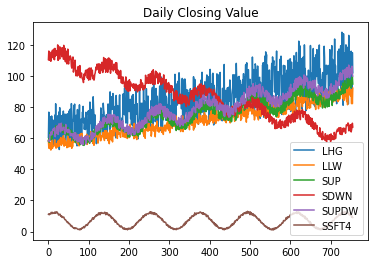

In [ ]:
plt.plot(lin_high_var_df["Close"].index, lin_high_var_df["Close"], label="LHG")
plt.plot(lin_low_var_df["Close"].index, lin_low_var_df["Close"], label="LLW")

plt.plot(sin_up_df["Close"].index, sin_up_df["Close"], label="SUP")
plt.plot(sin_down_df["Close"].index, sin_down_df["Close"], label="SDWN")

plt.plot(sin_up_down_df["Close"].index, sin_up_down_df["Close"], label="SUPDW")
plt.plot(sin_shift_4_df["Close"].index, sin_shift_4_df["Close"], label="SSFT4")

plt.title("Daily Closing Value")
plt.legend()
plt.show()

# Environment

## Agent

In [ ]:
policy = "MlpPolicy"
training_timesteps = 5
mixed_df = mixed_df

In [ ]:
AGENT_STR_TO_OBJECT = {
    "A2C": lambda pol, env, day: A2C(pol, env, n_steps=day),
    "DDPG": lambda pol, env, day: DDPG(pol, env),
    "PPO": lambda pol, env, day: PPO(pol, env, n_steps=day),
}

In [ ]:
TYPE_TO_NAMES = {
    "A2C": ["A2C1", "A2C2", "A2C3"],
    "DDPG": ["DDPG1", "DDPG2", "DDPG3"],
    "PPO": ["PPO1", "PPO2", "PPO3"],
    "Mixed": ["A2C", "DDPG", "PPO"],
}

In [ ]:
# configurations

stock_dimension = len(mixed_df["tic"].unique())
state_space = stock_dimension

env_kwargs = {
  "hmax": 100, 
  "initial_amount": 1000000, 
  "transaction_cost_pct": 0.001, 
  "state_space": state_space, 
  "stock_dim": stock_dimension, 
  "tech_indicator_list": [
    "volume_obv",
    "volume_adi", 
    "trend_adx", 
    "momentum_ao", 
    "trend_macd", 
    "momentum_rsi", 
    "momentum_stoch"
  ], 
  "action_space": stock_dimension, 
  "reward_scaling": 1e-4,
  "lookback": 126,
}

## Competitive

In [ ]:
class CompetitivePMEnv(gym.Env):
  metadata = {"render_modes": ["human"], "name": "marlpm_v1"}

  def __init__( 
      self,
      df,
      stock_dim,
      hmax,
      initial_amount,
      transaction_cost_pct,
      reward_scaling,
      state_space,
      action_space,
      tech_indicator_list,
      turbulence_threshold=None,
      lookback=252,
      day=0,
      render_mode=None,
      algo_type="Mixed", # default=mixed
  ):

    assert algo_type in ["A2C", "DDPG", "PPO", "Mixed"]

    # attributes
    self.lookback=lookback
    self.df = df
    self.stock_dim = stock_dim
    self.hmax = hmax
    self.initial_amount = initial_amount
    self.transaction_cost_pct =transaction_cost_pct
    self.reward_scaling = reward_scaling
    self.state_space = state_space
    self.action_dim = action_space
    self.tech_indicator_list = tech_indicator_list
    self.possible_agents = TYPE_TO_NAMES[algo_type]
    
    # buy/sell ratio reference, to explore
    self.end_day = len(self.df["Date"].unique()) - 1
    self.stock_volume_reference = 10000

    # spaces
    # check: spaces for observations only? sharing will affect?
    self.action_space = gym.spaces.Box(low = -1, high = 1, shape = (self.action_dim,))
    self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list), self.state_space))

    # agents
    self.agent_name_mapping = {
        agent: AGENT_STR_TO_OBJECT[algo_type](policy, self, self.end_day+1) for agent in self.possible_agents
    }
    self.training_agent = None
    self.day = {
        agent: day for agent in self.possible_agents
    }

    # data
    self.data = {
        agent: self.df.loc[self.day[agent]*self.state_space:self.day[agent]*self.state_space+self.state_space-1,:] for agent in self.possible_agents
    }
    self.covs = {
        agent: self.data[agent]['cov_list'].values[0] for agent in self.possible_agents
    }
    self.state = {
        agent: np.append(np.array(self.covs[agent]), [self.data[agent][tech].values.tolist() for tech in self.tech_indicator_list ], axis=0) for agent in self.possible_agents
    }
    self.terminal = False     
    self.turbulence_threshold = turbulence_threshold   

    # memory
    self.portfolio_value = {
        agent: self.initial_amount for agent in self.possible_agents
    }
    self.asset_memory = {
        agent: [self.initial_amount] for agent in self.possible_agents
    }
    self.portfolio_return_memory = {
        agent: [0] for agent in self.possible_agents
    }
    self.cum_portfolio_return_memory = {
        agent: [0] for agent in self.possible_agents
    }

    # stock ratio
    self.actions_memory = {
        agent: [[0]*self.stock_dim] for agent in self.possible_agents
    }
    self.date_memory = {
        agent: [self.data[agent]["Date"]] for agent in self.possible_agents
    }

    # free cash
    self.money_memory = {
        agent: [self.initial_amount] for agent in self.possible_agents
    }
    # cash + stock value
    self.total_value_memory = {
        agent: [self.initial_amount] for agent in self.possible_agents
    }
    # individual actions collection
    self.individual_preds = {
        agent: [] for agent in self.possible_agents
    }

    # render mode
    self.render_mode = render_mode

  def collect_individual_preds(self):
    self.individual_preds = {
        agent: [] for agent in self.possible_agents
    }
    for i in range(self.end_day+1):
      # states are somewhat static
      curr_data = self.df.loc[i*self.state_space:i*self.state_space+self.state_space-1,:]
      curr_covs = curr_data['cov_list'].values[0]
      curr_state = np.append(np.array(curr_covs), [curr_data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
      for agent in self.possible_agents:
        action, _states = self.agent_name_mapping[agent].predict(curr_state)
        self.individual_preds[agent].append(action)

  def step(self, actions):
    # termination
    self.terminal = self.day[self.training_agent] >= self.end_day

    if self.terminal:

      # uncomment to print metrics on terminal
      # print("=================================")
      # print("begin_money:{}".format(self.asset_memory[self.training_agent][0]))           
      # print("end_daily_total_portfolio_value:{}".format(self.total_value_memory[self.training_agent][-1]))
      # print("end_daily_portfolio_return:{}".format(self.portfolio_return_memory[self.training_agent][-1]))
      # print("end_cumulative_portfolio_return:{}".format(self.cum_portfolio_return_memory[self.training_agent][-1]))

      # df_daily_return = pd.DataFrame(self.portfolio_return_memory[self.training_agent])
      # df_daily_return.columns = ['daily_return']
      # if df_daily_return['daily_return'].std() !=0:
      #   sharpe = (252**0.5)*df_daily_return['daily_return'].mean() / df_daily_return['daily_return'].std()
      #   print("Sharpe: ",sharpe)
      # print("=================================")

      return self.state[self.training_agent], self.reward[self.training_agent], self.terminal, {}

    else:
      # loop through all agents so that each of them predict an action (portfolio weights)
      for agent in self.possible_agents:
        # get action
        if agent == self.training_agent:
          action = actions
        else:
          # action, _states = self.agent_name_mapping[agent].predict(self.state[agent], deterministic=False)
          action = self.individual_preds[agent][self.day[agent]]

        # normalisation
        weights = self.softmax_normalization(action) 

        # stock ratio - buy/sell/hold
        prev_stock_ratio = self.actions_memory[agent][-1]
        diff_stock_ratio = prev_stock_ratio - weights

        # money - increase if sell, decrease if buy, no changes if hold
        prev_money = self.money_memory[agent][-1]
        curr_money = prev_money + sum(diff_stock_ratio * self.stock_volume_reference * self.data[agent]["Close"].values)
        self.money_memory[agent].append(curr_money)

        # total value - money + currently held stock value
        curr_total = curr_money + sum(weights * self.stock_volume_reference * self.data[agent]["Close"].values)
        self.total_value_memory[agent].append(curr_total)

        # actions memory
        self.actions_memory[agent].append(weights)
        last_day_memory = self.data[agent]

        # load next state
        self.day[agent] += 1
        self.data[agent] = self.df.loc[self.day[agent]*self.state_space:self.day[agent]*self.state_space+self.state_space-1,:]
        self.covs[agent] = self.data[agent]['cov_list'].values[0]
        self.state[agent] =  np.append(np.array(self.covs[agent]), [self.data[agent][tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        
        # calculate portfolio return
        # individual stocks' return * weight
        portfolio_return = sum(((self.data[agent]["Close"].values / last_day_memory["Close"].values)-1)*weights)
        
        # save into memory
        self.portfolio_return_memory[agent].append(portfolio_return)
        self.cum_portfolio_return_memory[agent].append(self.cum_portfolio_return_memory[agent][-1] + portfolio_return)
        self.date_memory[agent].append(self.data[agent]["Date"])            
        self.asset_memory[agent].append(curr_total)

        # the reward is the new portfolio value or end portfolio value
        self.reward[agent] = curr_total 
        #self.reward = self.reward*self.reward_scaling
      
      # penalise or reward the target agent based on the result of all other agents
      all_rewards = list(self.reward.values())
      for agent in self.possible_agents:
        # ratio = current agent / other agent
        # if reward of current agent > other agent, ratio > 1, reward is increased
        # else ratio < 1, reward is penalised
        self.reward[agent] *= prod(self.reward[agent] / all_rewards)

        # if money on hand is negative, large penalty is applied as this is unwanted
        if self.money_memory[agent][-1] < 0:
          self.reward[agent] *= -1

    return self.state[agent], self.reward[self.training_agent], self.terminal, {}

  def reset(self, seed=None, return_info=False, options=None):
    # print("reset")

    # agents
    self.agents = self.possible_agents[:]

    # attributes
    self.day = {
        agent: 0 for agent in self.possible_agents
    }
    self.data = {
        agent: self.df.loc[self.day[agent]*self.state_space:self.day[agent]*self.state_space+self.state_space-1,:] for agent in self.possible_agents
    }
    self.covs = {
        agent: self.data[agent]['cov_list'].values[0] for agent in self.possible_agents
    }
    self.state = {
        agent: np.append(np.array(self.covs[agent]), [self.data[agent][tech].values.tolist() for tech in self.tech_indicator_list ], axis=0) for agent in self.possible_agents
    }

    # memory
    self.portfolio_value = {
        agent: self.initial_amount for agent in self.possible_agents
    }
    self.asset_memory = {
        agent: [self.initial_amount] for agent in self.possible_agents
    }
    self.portfolio_return_memory = {
        agent: [0] for agent in self.possible_agents
    }
    self.cum_portfolio_return_memory = {
        agent: [0] for agent in self.possible_agents
    }

    # stock ratio
    self.actions_memory = {
        agent: [[0]*self.stock_dim] for agent in self.possible_agents
    }
    self.date_memory = {
        agent: [self.data[agent]["Date"]] for agent in self.possible_agents
    }

    # free cash
    self.money_memory = {
        agent: [self.initial_amount] for agent in self.possible_agents
    }
    # cash + stock value
    self.total_value_memory = {
        agent: [self.initial_amount] for agent in self.possible_agents
    }

    # rewards
    self.reward = {
        agent: None for agent in self.possible_agents
    }
    
    # misc
    self.terminal = False 
    
    return self.state[self.training_agent] 

  def render(self):
    return self.state[self.training_agent]

  def seed(self, seed=None):
    self.np_random, seed = seeding.np_random(seed)
    return [seed]
  
  def softmax_normalization(self, actions):
    numerator = np.exp(actions)
    denominator = np.sum(np.exp(actions))
    softmax_output = numerator/denominator
    return softmax_output

  def set_training_agent(self, agent):
    # print(agent)
    self.training_agent = agent

  def learn(self, total_timesteps=1000):
    # run till terminal in each timestep
    for n in range(total_timesteps):
      print("Step:", n+1)
      self.collect_individual_preds()
      for agent in self.possible_agents:
        self.set_training_agent(agent)
        self.agent_name_mapping[agent] = self.agent_name_mapping[agent].learn(total_timesteps=1)
        
  def save_weights(self, num_it=100):
    for idx, agent in enumerate(self.possible_agents):
      self.agent_name_mapping[agent].save("comp_{}_{}.zip".format(agent, num_it))

  def load_weights(self, num_it=100):
    for idx, agent in enumerate(self.possible_agents):
      self.agent_name_mapping[agent].set_parameters("comp_{}_{}.zip".format(agent, num_it))
    
  def predict(self):
    self.set_training_agent(self.possible_agents[0])
    curr_state = self.reset()
    
    self.collect_individual_preds()
    for i in range(self.end_day):
      for agent in self.possible_agents:
        self.set_training_agent(agent)
        action, _ = self.agent_name_mapping[agent].predict(curr_state)
        curr_state, reward, term, _ = self.step(action)


### A2C

1. Train from scratch

In [ ]:
a2c_comp_env = CompetitivePMEnv(df=mixed_df, algo_type="A2C", **env_kwargs)
a2c_comp_env.learn(
    total_timesteps=training_timesteps,
)
a2c_comp_env.save_weights(num_it=100)

2. Analysis from Pretrained

In [ ]:
# initial iter=0

a2c_comp_init = CompetitivePMEnv(df=test_mixed_df, algo_type="A2C", **env_kwargs)
a2c_comp_init.predict()

In [ ]:
plot_line_graph(a2c_comp_init, range(0, a2c_comp_init.end_day+1), a2c_comp_init.cum_portfolio_return_memory, "A2C Initial Competitive CRR")

In [ ]:
# trained iter=100, load weights

a2c_comp_env = CompetitivePMEnv(df=mixed_df, algo_type="A2C", **env_kwargs)
a2c_comp_env.load_weights(num_it=100)
a2c_comp_env.predict()

In [ ]:
plot_line_graph(a2c_comp_env, range(0, a2c_comp_env.end_day+1), a2c_comp_env.cum_portfolio_return_memory, "A2C n=100 Competitive CRR")

In [ ]:
# trained iter=200

a2c_comp_env = CompetitivePMEnv(df=mixed_df, algo_type="A2C", **env_kwargs)
a2c_comp_env.load_weights(num_it=200)
a2c_comp_env.predict()

In [ ]:
plot_line_graph(a2c_comp_env, range(0, a2c_comp_env.end_day+1), a2c_comp_env.cum_portfolio_return_memory, "A2C n=200 Competitive CRR")

### DDPG

1. Train from scratch

In [ ]:
ddpg_comp_env = CompetitivePMEnv(df=mixed_df, algo_type="DDPG", **env_kwargs)
ddpg_comp_env.learn(
    total_timesteps=training_timesteps,
)
ddpg_comp_env.save_weights(num_it=100)

2. Analysis from Pretrained

In [ ]:
# initial iter=0

ddpg_comp_init = CompetitivePMEnv(df=mixed_df, algo_type="DDPG", **env_kwargs)
ddpg_comp_init.predict()

In [ ]:
plot_line_graph(ddpg_comp_init, range(0, ddpg_comp_init.end_day+1), ddpg_comp_init.cum_portfolio_return_memory, "DDPG Initial Competitive CRR")

In [ ]:
# trained iter=100, load weights

ddpg_comp_env = CompetitivePMEnv(df=mixed_df, algo_type="DDPG", **env_kwargs)
ddpg_comp_env.load_weights(num_it=100)
ddpg_comp_env.predict()

In [ ]:
plot_line_graph(ddpg_comp_env, range(0, ddpg_comp_env.end_day+1), ddpg_comp_env.cum_portfolio_return_memory, "DDPG n=100 Competitive CRR")

In [ ]:
# trained iter=200

ddpg_comp_env = CompetitivePMEnv(df=mixed_df, algo_type="DDPG", **env_kwargs)
ddpg_comp_env.load_weights(num_it=200)
ddpg_comp_env.predict()

In [ ]:
plot_line_graph(ddpg_comp_env, range(0, ddpg_comp_env.end_day+1), ddpg_comp_env.cum_portfolio_return_memory, "DDPG n=200 Competitive CRR")

### PPO

## Cooperative

In [ ]:
class CooperativePMEnv(gym.Env):
  metadata = {"render_modes": ["human"], "name": "marlpm_v1"}

  def __init__(
      self, 
      df,
      stock_dim,
      hmax,
      initial_amount,
      transaction_cost_pct,
      reward_scaling,
      state_space,
      action_space,
      tech_indicator_list,
      turbulence_threshold=None,
      lookback=252,
      day=0,
      render_mode=None,
      algo_type="Mixed", # default=mixed
  ):

    assert algo_type in ["A2C", "DDPG", "PPO", "Mixed"]

    # attributes
    self.lookback=lookback
    self.df = df
    self.stock_dim = stock_dim
    self.hmax = hmax
    self.initial_amount = initial_amount
    self.transaction_cost_pct =transaction_cost_pct
    self.reward_scaling = reward_scaling
    self.state_space = state_space
    self.action_dim = action_space
    self.tech_indicator_list = tech_indicator_list
    self.possible_agents = TYPE_TO_NAMES[algo_type]
    
    # buy/sell ratio reference, to explore
    self.end_day = len(self.df["Date"].unique()) - 1
    self.stock_volume_reference = 10000

    # spaces
    # check: spaces for observations only? sharing will affect?
    self.action_space = gym.spaces.Box(low = -1, high = 1, shape = (self.action_dim,))
    self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list), self.state_space))

    # agents
    self.agent_name_mapping = {
        agent: AGENT_STR_TO_OBJECT[algo_type](policy, self, self.end_day+1) for agent in self.possible_agents
    }
    self.training_agent = None
    self.day = {
        agent: day for agent in self.possible_agents
    }

    # data
    self.data = {
        agent: self.df.loc[self.day[agent]*self.state_space:self.day[agent]*self.state_space+self.state_space-1,:] for agent in self.possible_agents
    }
    self.covs = {
        agent: self.data[agent]['cov_list'].values[0] for agent in self.possible_agents
    }
    self.state = {
        agent: np.append(np.array(self.covs[agent]), [self.data[agent][tech].values.tolist() for tech in self.tech_indicator_list ], axis=0) for agent in self.possible_agents
    }
    self.terminal = False     
    self.turbulence_threshold = turbulence_threshold   

    # memory
    self.portfolio_value = {
        agent: self.initial_amount for agent in self.possible_agents
    }
    self.asset_memory = {
        agent: [self.initial_amount] for agent in self.possible_agents
    }
    self.portfolio_return_memory = {
        agent: [0] for agent in self.possible_agents
    }
    self.cum_portfolio_return_memory = {
        agent: [0] for agent in self.possible_agents
    }

    # stock ratio
    self.actions_memory = {
        agent: [[0]*self.stock_dim] for agent in self.possible_agents
    }
    self.date_memory = {
        agent: [self.data[agent]["Date"].unique()[0]] for agent in self.possible_agents
    }

    # free cash
    self.money_memory = {
        agent: [self.initial_amount] for agent in self.possible_agents
    }
    # cash + stock value
    self.total_value_memory = {
        agent: [self.initial_amount] for agent in self.possible_agents
    }
    # individual actions collection
    self.individual_preds = {
        agent: [] for agent in self.possible_agents
    }

    # render mode
    self.render_mode = render_mode

  def collect_individual_preds(self):
    self.individual_preds = {
        agent: [] for agent in self.possible_agents
    }
    for i in range(self.end_day+1):
      # states are somewhat static
      curr_data = self.df.loc[i*self.state_space:i*self.state_space+self.state_space-1,:]
      curr_covs = curr_data['cov_list'].values[0]
      curr_state = np.append(np.array(curr_covs), [curr_data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
      for agent in self.possible_agents:
        action, _states = self.agent_name_mapping[agent].predict(curr_state)
        self.individual_preds[agent].append(action)
  
  def step(self, actions):

    # termination
    self.terminal = self.day[self.training_agent] >= self.end_day

    if self.terminal:

      # uncomment to print metrics on terminal
      # print("=================================")
      # print("begin_money:{}".format(self.asset_memory[self.training_agent][0]))           
      # print("end_daily_total_portfolio_value:{}".format(self.total_value_memory[self.training_agent][-1]))
      # print("end_daily_portfolio_return:{}".format(self.portfolio_return_memory[self.training_agent][-1]))
      # print("end_cumulative_portfolio_return:{}".format(self.cum_portfolio_return_memory[self.training_agent][-1]))

      # df_daily_return = pd.DataFrame(self.portfolio_return_memory[self.training_agent])
      # df_daily_return.columns = ['daily_return']
      # if df_daily_return['daily_return'].std() !=0:
      #   sharpe = (252**0.5)*df_daily_return['daily_return'].mean() / df_daily_return['daily_return'].std()
      #   print("Sharpe: ",sharpe)
      # print("=================================")

      return self.state[self.training_agent], self.reward[self.training_agent], self.terminal, {}

    else:
      # loop through all agents so that each of them predict an action (portfolio weights)
      for agent in self.possible_agents:
        # get action
        if agent == self.training_agent:
          action = actions
        else:
          # action, _states = self.agent_name_mapping[agent].predict(self.state[agent], deterministic=False)
          action = self.individual_preds[agent][self.day[agent]]

        # normalisation
        weights = self.softmax_normalization(action) 

        # stock ratio - buy/sell/hold
        prev_stock_ratio = self.actions_memory[agent][-1]
        diff_stock_ratio = prev_stock_ratio - weights

        # money - increase if sell, decrease if buy, no changes if hold
        prev_money = self.money_memory[agent][-1]
        curr_money = prev_money + sum(diff_stock_ratio * self.stock_volume_reference * self.data[agent]["Close"].values)
        self.money_memory[agent].append(curr_money)

        # total value - money + currently held stock value
        curr_total = curr_money + sum(weights * self.stock_volume_reference * self.data[agent]["Close"].values)
        self.total_value_memory[agent].append(curr_total)

        # actions memory
        self.actions_memory[agent].append(weights)
        last_day_memory = self.data[agent]

        # load next state
        self.day[agent] += 1
        self.data[agent] = self.df.loc[self.day[agent]*self.state_space:self.day[agent]*self.state_space+self.state_space-1,:]
        self.covs[agent] = self.data[agent]['cov_list'].values[0]
        self.state[agent] =  np.append(np.array(self.covs[agent]), [self.data[agent][tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        
        # calculate portfolio return
        # individual stocks' return * weight
        portfolio_return = sum(((self.data[agent]["Close"].values / last_day_memory["Close"].values)-1)*weights)

        # save into memory
        self.portfolio_return_memory[agent].append(portfolio_return)
        self.cum_portfolio_return_memory[agent].append(self.cum_portfolio_return_memory[agent][-1] + portfolio_return)
        self.date_memory[agent].append(self.data[agent]["Date"].unique()[0])            
        self.asset_memory[agent].append(curr_total)

        # the reward is the new portfolio value or end portfolio value
        self.reward[agent] = curr_total 
        #self.reward = self.reward*self.reward_scaling
      
      # penalise or reward the target agent based on the result of all other agents
      all_rewards = list(self.reward.values())
      for agent in self.possible_agents:
        # ratio = smaller reward / greater reward
        # rewards have to be similar across all agents
        # the greater the difference, the greater the penalty
        self.reward[agent] *= prod([
            pv / self.reward[agent]
            if self.reward[agent] > pv
            else self.reward[agent] / pv
            for pv in all_rewards
        ])

        # if money on hand is negative, large penalty is applied as this is unwanted
        if self.money_memory[agent][-1] < 0:
          self.reward[agent] *= -1

    return self.state[agent], self.reward[self.training_agent], self.terminal, {}

  def reset(self, seed=None, return_info=False, options=None):
    # print("reset")

    # agents
    self.agents = self.possible_agents[:]

    # attributes
    self.day = {
        agent: 0 for agent in self.possible_agents
    }
    self.data = {
        agent: self.df.loc[self.day[agent]*self.state_space:self.day[agent]*self.state_space+self.state_space-1,:] for agent in self.possible_agents
    }
    self.covs = {
        agent: self.data[agent]['cov_list'].values[0] for agent in self.possible_agents
    }
    self.state = {
        agent: np.append(np.array(self.covs[agent]), [self.data[agent][tech].values.tolist() for tech in self.tech_indicator_list ], axis=0) for agent in self.possible_agents
    }

    # memory
    self.portfolio_value = {
        agent: self.initial_amount for agent in self.possible_agents
    }
    self.asset_memory = {
        agent: [self.initial_amount] for agent in self.possible_agents
    }
    self.portfolio_return_memory = {
        agent: [0] for agent in self.possible_agents
    }
    self.cum_portfolio_return_memory = {
        agent: [0] for agent in self.possible_agents
    }

    # stock ratio
    self.actions_memory = {
        agent: [[0]*self.stock_dim] for agent in self.possible_agents
    }
    self.date_memory = {
        agent: [self.data[agent]["Date"].unique()[0]] for agent in self.possible_agents
    }

    # free cash
    self.money_memory = {
        agent: [self.initial_amount] for agent in self.possible_agents
    }
    # cash + stock value
    self.total_value_memory = {
        agent: [self.initial_amount] for agent in self.possible_agents
    }

    # rewards
    self.reward = {
        agent: None for agent in self.possible_agents
    }
    
    # misc
    self.terminal = False 
    
    return self.state[self.training_agent] 

  def render(self):
    return self.state[self.training_agent]

  def seed(self, seed=None):
    self.np_random, seed = seeding.np_random(seed)
    return [seed]
  
  def softmax_normalization(self, actions):
    numerator = np.exp(actions)
    denominator = np.sum(np.exp(actions))
    softmax_output = numerator/denominator
    return softmax_output

  def set_training_agent(self, agent):
    # print(agent)
    self.training_agent = agent

  def learn(self, total_timesteps=1000):
    # run till terminal in each timestep
    for n in range(total_timesteps):
      print("Step:", n+1)
      self.collect_individual_preds()
      for agent in self.possible_agents:
        self.set_training_agent(agent)
        self.agent_name_mapping[agent] = self.agent_name_mapping[agent].learn(total_timesteps=1)
        
  def save_weights(self, num_it=100):
    for idx, agent in enumerate(self.possible_agents):
      self.agent_name_mapping[agent].save("coop_{}_{}.zip".format(agent, num_it))

  def load_weights(self, num_it=100):
    for idx, agent in enumerate(self.possible_agents):
      self.agent_name_mapping[agent].set_parameters("coop_{}_{}.zip".format(agent, num_it))

  def predict(self):
    self.set_training_agent(self.possible_agents[0])
    curr_state = self.reset()
    
    self.collect_individual_preds()
    for i in range(self.end_day):
      for agent in self.possible_agents:
        self.set_training_agent(agent)
        action, _ = self.agent_name_mapping[agent].predict(curr_state)
        curr_state, reward, term, _ = self.step(action)

### A2C

### DDPG

1. Train from scratch

In [ ]:
ddpg_coop_env = CompetitivePMEnv(df=mixed_df, algo_type="DDPG", **env_kwargs)
ddpg_coop_env.learn(
    total_timesteps=training_timesteps,
)
ddpg_coop_env.save_weights(num_it=100)

2. Analysis from Pretrained

In [ ]:
ddpg_coop_init = CooperativePMEnv(df=mixed_df, algo_type="DDPG", **env_kwargs)
ddpg_coop_init.predict()

In [ ]:
plot_line_graph(ddpg_coop_init, range(0, ddpg_coop_init.end_day+1), ddpg_coop_init.cum_portfolio_return_memory, "DDPG Initial Cooperative CRR")

In [ ]:
# trained iter=100, load weights

ddpg_coop_env = CompetitivePMEnv(df=mixed_df, algo_type="DDPG", **env_kwargs)
ddpg_coop_env.load_weights(num_it=100)
ddpg_coop_env.predict()

In [ ]:
plot_line_graph(ddpg_coop_env, range(0, ddpg_coop_env.end_day+1), ddpg_coop_env.cum_portfolio_return_memory, "DDPG n=100 Cooperative CRR")

In [ ]:
# trained iter=200, load weights

ddpg_coop_env = CompetitivePMEnv(df=mixed_df, algo_type="DDPG", **env_kwargs)
ddpg_coop_env.load_weights(num_it=200)
ddpg_coop_env.predict()

In [ ]:
plot_line_graph(ddpg_coop_env, range(0, ddpg_coop_env.end_day+1), ddpg_coop_env.cum_portfolio_return_memory, "DDPG n=200 Cooperative CRR")

### PPO

# Benchmark
After the strategies have been construct, we are going to use buy and hold and constance_rebalancing to compare the efficiency of the algorithm.
We are using DRR, CRR, Varience, and Sharpe ratio to measure the performance of the benchmark algo.

### DRR
The Daily rate of return can be computed by

$$ DRR = { Price_{today} - Price_{prevday}} $$

In [ ]:
# use DRR column
def portfolio_daily_rate_of_return(portfolio_df, initial_amount):
    if not ('DRR' in portfolio_df):
        portfolio_df['DRR'] = np.nan
    portfolio_df['DRR'] = ( portfolio_df['Sum'] - np.roll(portfolio_df['Sum'], shift=1))/portfolio_df['Sum']
    portfolio_df.loc[portfolio_df.index[0], 'DRR']= (portfolio_df.loc[portfolio_df.index[0], 'Sum'] -initial_amount) /initial_amount
    return portfolio_df 


### CRR
The Cumulative rate or the sum of the DRR can be computed by

$$ CRR = { Price_{today} - Price_{init}} $$

In [ ]:
# use CRR column
def portfolio_cumulative_rate_of_return(portfolio_df, initial_amount):
    if not ('DRR' in portfolio_df):
        portfolio_df = portfolio_daily_rate_of_return(portfolio_df, initial_amount)
    if not ('CRR' in portfolio_df):
        portfolio_df['CRR'] = np.nan
    
    portfolio_df['CRR'] = ( portfolio_df['Sum'] - initial_amount)/initial_amount

    return portfolio_df 

In [ ]:
def portfolio_get_cumulative_rate_of_return(portfolio_df, index=-1):
    return portfolio_df.loc[portfolio_df.index[index], 'CRR']

### Varience
The Varience can be computed by using the following equation

$$ Var = { \Sigma( DRR - E_{DRR} )^2 \over Time} $$

In [ ]:
def portfolio_varience(portfolio_df):
    drr_sum = portfolio_df.loc[portfolio_df.index[-1], 'CRR']/portfolio_df.__len__()
    diff_sq = np.square(portfolio_df['DRR'] - drr_sum)
    var = diff_sq.sum()/portfolio_df.__len__()
    return var

### Sharpe ratio
The ratio can be computed by using the following equation

$$ Sharpe = { R_{portfolio} - R_{riskfree} \over \sigma_{portfolio}} $$

In [ ]:
# compute the portfolio sharpe ratio
def portfolio_sharpe_ratio(portfolio_df, port_sd, riskfree=0.0151, at_index=-1):
    year_count = portfolio_df.__len__()/252
    asset_return = portfolio_df.loc[portfolio_df.index[at_index], 'CRR']/year_count
    return (asset_return - riskfree)/port_sd

### Define a class for running rebalancing algo

In [ ]:
class ConstanceBalancingOnTime:
    def __init__(self, 
                df,
                holding_ratio,
                rebalance_time,
                initial_amount,
                transaction_cost_pct,
                lookback=252,
                day = 0):
        self.df = df
        self.rebalance_time = rebalance_time
        self.holding_ratio = np.array(holding_ratio)
        self.initial_amount = initial_amount
        self.transaction_cost_pct = transaction_cost_pct
        self.lookback = lookback
        self.day = day

        self.ticker_list = df["tic"].unique()
        self.stock_count = len(self.ticker_list)
        # the first one is cash on hand followed by the stock in the tickers
        self.asset_amount = self.holding_ratio * initial_amount

        self.portfolio_memory = self._create_initial_memory()
        self._write_memory_at_index(0)

        #for keeping matric
        self.metric = {}

        

    def step(self):
        # incase 
        self.day += 1
        # if (self.day == 1):
        #     current_value = self.initial_amount / (self.transaction_cost_pct * self.holding_ratio[1:].sum() + self.initial_amount)
        #     self.asset_amount = current_value * self.holding_ratio
        #     return
        
        for index in range(self.stock_count):
            try:
                self.asset_amount[index+1] *= self._update_assetprice_by_ratio(int(self.day), self.ticker_list[index])
            except:
                print("error at day",self.day, index)
        
        # rebalancing
        if (self.day % self.rebalance_time == 0):

            after_asset_amount = np.array([])
            
            current_asset_value = self.asset_amount.sum()
            current_asset_ratio = self.asset_amount/current_asset_value

            #check the sign of asset allowcation
            asset_adapt_sign = self.holding_ratio >= current_asset_ratio
                
            asset_matrix = np.array([np.append(self.holding_ratio.copy(), 0)])
            
            for i in range(self.stock_count+1): 
                # the amount of add in that we will add into the asset line
                add_in_asset_line = 1
                if ((self.holding_ratio == current_asset_ratio)[i] ):
                    pass
                elif (asset_adapt_sign[i] ):
                    add_in_asset_line += self.transaction_cost_pct
                else:
                    add_in_asset_line -= self.transaction_cost_pct
                # print(add_in_asset_line)
                current_asset_line = np.zeros(self.stock_count+2)
                current_asset_line[i] = add_in_asset_line
                current_asset_line[-1] = 1
                # print(asset_matrix.shape, current_asset_line.shape)
                # print(asset_matrix, current_asset_line)
                asset_matrix = np.append(asset_matrix.copy(), np.array([current_asset_line.copy()]), axis=0)
            asset_matrix = asset_matrix.T
            
            modify_amount = np.linalg.solve(asset_matrix, np.append(self.asset_amount, 0))[1:]
            self.asset_amount = self.asset_amount - modify_amount
        
        # write the allocation to the memory df
        self._write_memory_at_index(self.day)

    def run(self):
        time_range = self.df.__len__() / self.stock_count
        for i in range(int(time_range)-1):
            self.step()

    def reset(self):
        self.day = 0
        self.asset_amount = self.holding_ratio * self.initial_amount

        self.portfolio_memory = self._create_initial_memory()
        self._write_memory_at_index(0)

    def get_asset_amount(self):
        return self.asset_amount.sum()
    
    def add_return(self, method):
        self.portfolio_memory = method(self.portfolio_memory, self.initial_amount)

    def add_metric(self, new_matric, new_matric_name, **kwargs):
        matric_res = new_matric(self.portfolio_memory, **kwargs)
        self.metric.update({new_matric_name: matric_res}) 

    def _create_initial_memory(self):
        col = np.append(np.array(['Cash']), self.ticker_list)
        col = np.append(col, np.array(['Sum']))
        initial_memory = pd.DataFrame(index=self.df.index.unique(), columns=col)
        
        return initial_memory
    
    def _update_assetprice_by_ratio(self, time_index: int, ticker: str):
        return self.df[self.df['tic'] == ticker].iloc[time_index]['Close']/self.df[self.df['tic'] == ticker].iloc[time_index-1]['Close']
    
    def _write_memory_at_index(self, index: int):
        self.portfolio_memory.iloc[index]['Cash'] = self.asset_amount[0]
        
        for stock_index in range(self.stock_count):
            current_ticker = self.ticker_list[stock_index]
            self.portfolio_memory.iloc[index][current_ticker] = self.asset_amount[stock_index+1]
        self.portfolio_memory.iloc[index]['Sum'] = self.asset_amount.sum()
    


In [ ]:
mixed_df["tic"].unique()

array(['AAPL', 'CAAS'], dtype=object)

In [ ]:
#df for testing
test_df = mixed_df.copy().set_index('Date')
risk_free_2022 = 0.025

#### Single stock

In [ ]:
env_kwargs = {
  "holding_ratio": [0, 0.5], 
  "rebalance_time": 60,
  "initial_amount": 1000000, 
  "transaction_cost_pct": 0.001
}

cr = ConstanceBalancingOnTime(df = new_aapl_df.copy().set_index('Date'), **env_kwargs)


In [ ]:
cr.reset()
cr.run()

In [ ]:
cr.add_return(portfolio_daily_rate_of_return)
cr.add_return(portfolio_cumulative_rate_of_return)

cr.add_metric(portfolio_varience, "varience")
cr.add_metric(portfolio_get_cumulative_rate_of_return, "crr")
env_kwargs = {
  "port_sd": np.sqrt(cr.metric['varience']), 
  "riskfree": risk_free_2022,
}

cr.add_metric(portfolio_sharpe_ratio, "sharpe", **env_kwargs)


In [ ]:
print("rebalance time", cr.rebalance_time)
print("initial amount", cr.initial_amount)
print("tickers", cr.ticker_list)
print("stock count", cr.stock_count)

cr.metric

rebalance time 60
initial amount 1000000
tickers ['AAPL']
stock count 1


{'varience': 0.0007138874448694907,
 'crr': 0.8275545459579413,
 'sharpe': 6.815237131372679}

#### Constance rebalance

In [ ]:
env_kwargs = {
  "holding_ratio": [0,0.5, 0.5], 
  "rebalance_time": 60,
  "initial_amount": 1000000, 
  "transaction_cost_pct": 0.001
}

cr = ConstanceBalancingOnTime(df = test_df, **env_kwargs)


In [ ]:
cr.reset()
cr.run()

In [ ]:
cr.add_return(portfolio_daily_rate_of_return)
cr.add_return(portfolio_cumulative_rate_of_return)

cr.add_metric(portfolio_varience, "varience")
cr.add_metric(portfolio_get_cumulative_rate_of_return, "crr")
env_kwargs = {
  "port_sd": np.sqrt(cr.metric['varience']), 
  "riskfree": risk_free_2022,
}

cr.add_metric(portfolio_sharpe_ratio, "sharpe", **env_kwargs)


In [ ]:
print("rebalance time", cr.rebalance_time)
print("initial amount", cr.initial_amount)
print("tickers", cr.ticker_list)
print("stock count", cr.stock_count)

cr.metric

rebalance time 60
initial amount 1000000
tickers ['AAPL' 'CAAS']
stock count 2


{'varience': 0.0010014236330381694,
 'crr': 2.60775359627078,
 'sharpe': 19.831894080392228}

### Buy and Hold

In [ ]:
## let the time to be very high so the portfolio will not rebalance
env_kwargs = {
  "holding_ratio": [0,0.5,0.5], 
  "rebalance_time": 9999999999,
  "initial_amount": 1000000, 
  "transaction_cost_pct": 0.001
}

buyhold = ConstanceBalancingOnTime(df = test_df, **env_kwargs)


In [ ]:
buyhold.reset()
buyhold.run()

In [ ]:
buyhold.add_return(portfolio_daily_rate_of_return)
buyhold.add_return(portfolio_cumulative_rate_of_return)
buyhold.add_metric(portfolio_varience, "varience")
buyhold.add_metric(portfolio_get_cumulative_rate_of_return, "crr")
env_kwargs = {
  "port_sd": np.sqrt(cr.metric['varience']), 
  "riskfree": risk_free_2022,
}

buyhold.add_metric(portfolio_sharpe_ratio, "sharpe", **env_kwargs)

In [ ]:
print("rebalance time", buyhold.rebalance_time)
print("initial amount", buyhold.initial_amount)
print("tickers", buyhold.ticker_list)
print("stock count", buyhold.stock_count)

buyhold.metric


rebalance time 9999999999
initial amount 1000000
tickers ['AAPL' 'CAAS']
stock count 2


{'varience': 0.0006593813320346426,
 'crr': 1.9875545841049216,
 'sharpe': 14.927411207558738}